In [3]:
!pip install seaborn 
!pip install requests

    100% |████████████████████████████████| 163kB 1.7MB/s ta 0:00:01
  Running setup.py bdist_wheel for seaborn ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/cb/c8/67/83d615c0ef9b529558525aa521025b183de8c5b156799b091e
Successfully built seaborn
    100% |████████████████████████████████| 593kB 429kB/s ta 0:00:011   56% |██████████████████              | 327kB 2.9MB/s eta 0:00:01


In [4]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://drive.google.com/uc?export=download&id=0B16OiWl7I-fBM29rcDFCTGRnc2s"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

if __name__ == "__main__":
    file_id = '0B16OiWl7I-fBM29rcDFCTGRnc2s'
    destination = 'creditcard.csv'
    download_file_from_google_drive(file_id, destination)
    #https://drive.google.com/file/d/0B16OiWl7I-fBM29rcDFCTGRnc2s/view?usp=sharing

#  Credit Card Fraud

 More about the data: https://www.kaggle.com/dalpozz/creditcardfraud.



In [1]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
# from show_confusion_matrix import show_confusion_matrix 
# the above is from http://notmatthancock.github.io/2015/10/28/confusion-matrix.html

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
df = pd.read_csv("creditcard.csv")

## Explore

In [8]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [10]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [11]:
print ("Fraud")
print (df.Time[df.Class == 1].describe())
print ()
print ("Normal")
print (df.Time[df.Class == 0].describe())

Fraud
count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64
()
Normal
count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


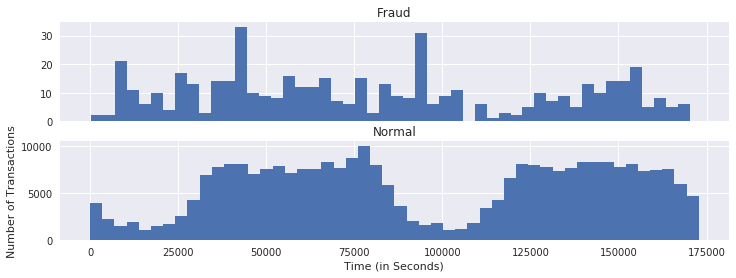

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(df.Time[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Time[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

In [13]:
print ("Fraud")
print (df.Amount[df.Class == 1].describe())
print ()
print ("Normal")
print (df.Amount[df.Class == 0].describe())

Fraud
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64
()
Normal
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


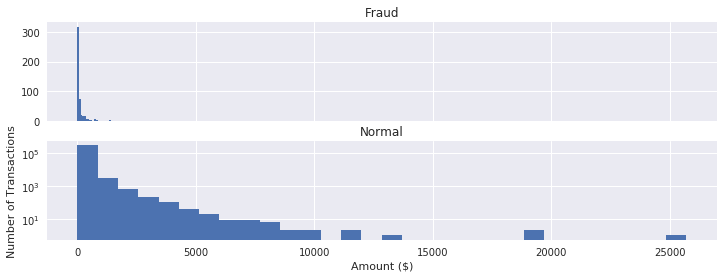

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 30

ax1.hist(df.Amount[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Amount[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

In [15]:
df['Amount_max_fraud'] = 1
df.loc[df.Amount <= 2125.87, 'Amount_max_fraud'] = 0

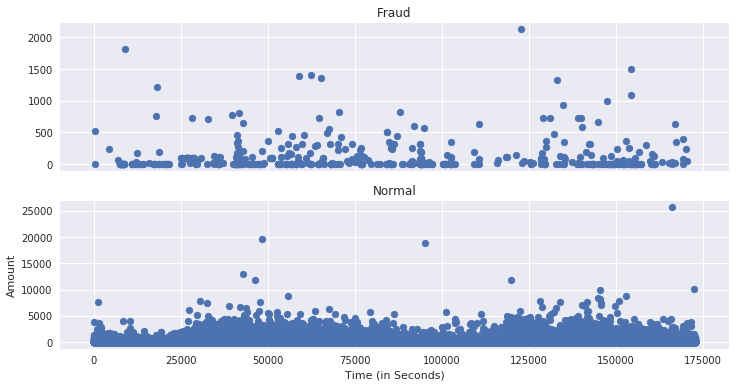

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,6))

ax1.scatter(df.Time[df.Class == 1], df.Amount[df.Class == 1])
ax1.set_title('Fraud')

ax2.scatter(df.Time[df.Class == 0], df.Amount[df.Class == 0])
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [17]:

v_features = df.ix[:,1:29].columns

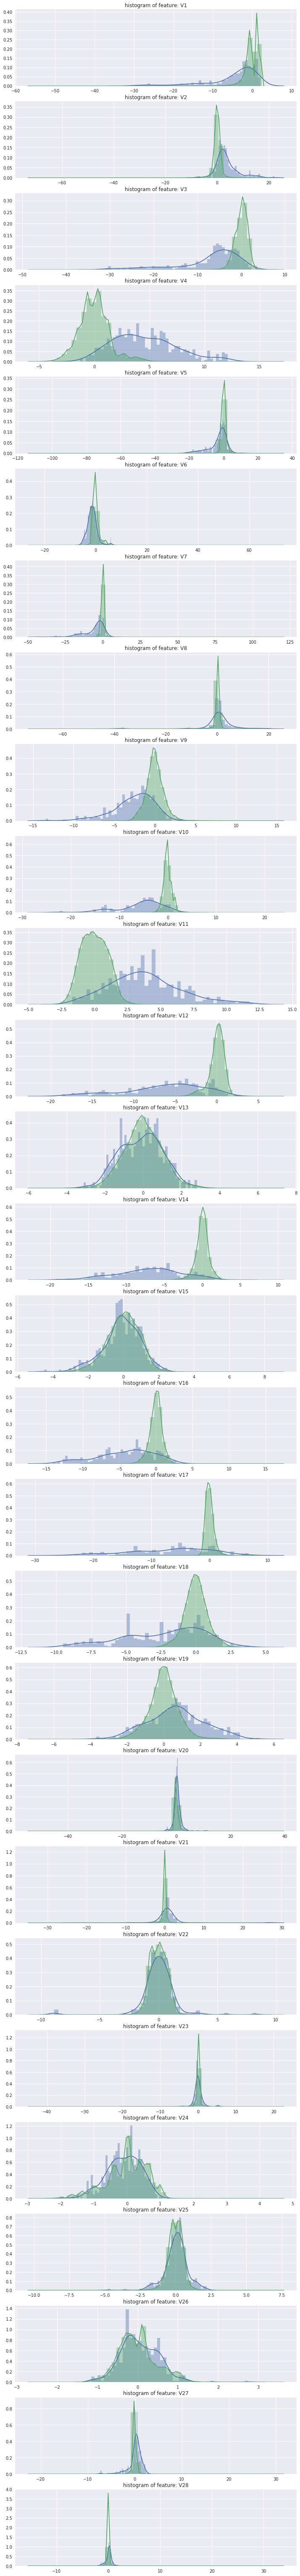

In [18]:
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(df[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

In [ ]:
#Drop similar features
df = df.drop(['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8'], axis =1)

In [21]:
# features are created to identify values 
df['V1_'] = df.V1.map(lambda x: 1 if x < -3 else 0)
df['V2_'] = df.V2.map(lambda x: 1 if x > 2.5 else 0)
df['V3_'] = df.V3.map(lambda x: 1 if x < -4 else 0)
df['V4_'] = df.V4.map(lambda x: 1 if x > 2.5 else 0)
df['V5_'] = df.V5.map(lambda x: 1 if x < -4.5 else 0)
df['V6_'] = df.V6.map(lambda x: 1 if x < -2.5 else 0)
df['V7_'] = df.V7.map(lambda x: 1 if x < -3 else 0)
df['V9_'] = df.V9.map(lambda x: 1 if x < -2 else 0)
df['V10_'] = df.V10.map(lambda x: 1 if x < -2.5 else 0)
df['V11_'] = df.V11.map(lambda x: 1 if x > 2 else 0)
df['V12_'] = df.V12.map(lambda x: 1 if x < -2 else 0)
df['V14_'] = df.V14.map(lambda x: 1 if x < -2.5 else 0)
df['V16_'] = df.V16.map(lambda x: 1 if x < -2 else 0)
df['V17_'] = df.V17.map(lambda x: 1 if x < -2 else 0)
df['V18_'] = df.V18.map(lambda x: 1 if x < -2 else 0)
df['V19_'] = df.V19.map(lambda x: 1 if x > 1.5 else 0)
df['V21_'] = df.V21.map(lambda x: 1 if x > 0.6 else 0)

In [22]:
#(non-fraudulent) transactions.
df.loc[df.Class == 0, 'Normal'] = 1
df.loc[df.Class == 1, 'Normal'] = 0

In [23]:

df = df.rename(columns={'Class': 'Fraud'})

In [24]:

#% of transactions were fraud. 
print(df.Normal.value_counts())
print()
print(df.Fraud.value_counts())

1.0    284315
0.0       492
Name: Normal, dtype: int64
()
0    284315
1       492
Name: Fraud, dtype: int64


In [25]:
pd.set_option("display.max_columns",101)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,Amount,Fraud,Amount_max_fraud,V1_,V2_,V3_,V4_,V5_,V6_,V7_,V9_,V10_,V11_,V12_,V14_,V16_,V17_,V18_,V19_,V21_,Normal
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,-0.018307,149.62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.225775,2.69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.247998,378.66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.108300,123.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,-0.009431,69.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0


In [ ]:
#Fraud vs Normal
Fraud = df[df.Fraud == 1]
Normal = df[df.Normal == 1]

In [27]:

X_train = Fraud.sample(frac=0.8)
count_Frauds = len(X_train)


X_train = pd.concat([X_train, Normal.sample(frac = 0.8)], axis = 0)


X_test = df.loc[~df.index.isin(X_train.index)]

In [28]:
#Shuffle 
X_train = shuffle(X_train)
X_test = shuffle(X_test)

In [29]:
#target
y_train = X_train.Fraud
y_train = pd.concat([y_train, X_train.Normal], axis=1)

y_test = X_test.Fraud
y_test = pd.concat([y_test, X_test.Normal], axis=1)

In [30]:

X_train = X_train.drop(['Fraud','Normal'], axis = 1)
X_test = X_test.drop(['Fraud','Normal'], axis = 1)

In [31]:

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

227846
227846
56961
56961


In [32]:

ratio = len(X_train)/count_Frauds 

y_train.Fraud *= ratio
y_test.Fraud *= ratio

In [34]:

features = X_train.columns.values


for feature in features:
    mean, std = df[feature].mean(), df[feature].std()
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std

## Train the Neural Net

In [40]:

split = int(len(y_test)/2)

inputX = X_train.as_matrix()
inputY = y_train.as_matrix()
inputX_valid = X_test.as_matrix()[:split]
inputY_valid = y_test.as_matrix()[:split]
inputX_test = X_test.as_matrix()[split:]
inputY_test = y_test.as_matrix()[split:]

In [39]:

input_nodes = 37
mulitplier = 1.5 

hidden_nodes1 = 18
hidden_nodes2 = round(hidden_nodes1 * mulitplier)
hidden_nodes3 = round(hidden_nodes2 * mulitplier)

pkeep = tf.placeholder(tf.float32)

In [ ]:
# input
x = tf.placeholder(tf.float32, [None, input_nodes])

# layer 1
W1 = tf.Variable(tf.truncated_normal([input_nodes, hidden_nodes1], stddev = 0.15))
b1 = tf.Variable(tf.zeros([hidden_nodes1]))
y1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

# layer 2
W2 = tf.Variable(tf.truncated_normal([hidden_nodes1, hidden_nodes2], stddev = 0.15))
b2 = tf.Variable(tf.zeros([hidden_nodes2]))
y2 = tf.nn.sigmoid(tf.matmul(y1, W2) + b2)

# layer 3
W3 = tf.Variable(tf.truncated_normal([hidden_nodes2, hidden_nodes3], stddev = 0.15)) 
b3 = tf.Variable(tf.zeros([hidden_nodes3]))
y3 = tf.nn.sigmoid(tf.matmul(y2, W3) + b3)
y3 = tf.nn.dropout(y3, pkeep)

# layer 4
W4 = tf.Variable(tf.truncated_normal([hidden_nodes3, 2], stddev = 0.15)) 
b4 = tf.Variable(tf.zeros([2]))
y4 = tf.nn.softmax(tf.matmul(y3, W4) + b4)

# output
y = y4
y_ = tf.placeholder(tf.float32, [None, 2])

In [ ]:
# Parameters
training_epochs = 5 # should be 2000, it will timeout when uploading
training_dropout = 0.9
display_step = 1 # 10 
n_samples = y_train.shape[0]
batch_size = 2048
learning_rate = 0.005

In [ ]:

cost = -tf.reduce_sum(y_ * tf.log(y))


optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
accuracy_summary = [] t
cost_summary = [] 
valid_accuracy_summary = [] 
valid_cost_summary = [] 
stop_early = 

saver = tf.train.Saver(max_to_keep=1)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs): 
        for batch in range(int(n_samples/batch_size)):
            batch_x = inputX[batch*batch_size : (1+batch)*batch_size]
            batch_y = inputY[batch*batch_size : (1+batch)*batch_size]

            sess.run([optimizer], feed_dict={x: batch_x, 
                                             y_: batch_y,
                                             pkeep: training_dropout})

        
        if (epoch) % display_step == 0:
            train_accuracy, newCost = sess.run([accuracy, cost], feed_dict={x: inputX, 
                                                                            y_: inputY,
                                                                            pkeep: training_dropout})

            valid_accuracy, valid_newCost = sess.run([accuracy, cost], feed_dict={x: inputX_valid, 
                                                                                  y_: inputY_valid,
                                                                                  pkeep: 1})

            print ("Epoch:", epoch,
                   "Acc =", "{:.5f}".format(train_accuracy), 
                   "Cost =", "{:.5f}".format(newCost),
                   "Valid_Acc =", "{:.5f}".format(valid_accuracy), 
                   "Valid_Cost = ", "{:.5f}".format(valid_newCost))
            
           
            accuracy_summary.append(train_accuracy)
            cost_summary.append(newCost)
            valid_accuracy_summary.append(valid_accuracy)
            valid_cost_summary.append(valid_newCost)
            
            # If the model does not improve after 15 logs, stop the training.
            if valid_accuracy < max(valid_accuracy_summary) and epoch > 100:
                stop_early += 1
                if stop_early == 15:
                    break
            else:
                stop_early = 0
            
    print()
    print("Optimization Finished!")
    print()   
    


In [ ]:
# Plot the accuracy and cost summaries 
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,4))

ax1.plot(accuracy_summary) # blue
ax1.plot(valid_accuracy_summary) # green
ax1.set_title('Accuracy')

ax2.plot(cost_summary)
ax2.plot(valid_cost_summary)
ax2.set_title('Cost')

plt.xlabel('Epochs (x10)')
plt.show()

##  t-SNE

In [2]:
#reload the original dataset
tsne_data = pd.read_csv("creditcard.csv")

In [3]:

df2 = tsne_data[tsne_data.Class == 1]
df2 = pd.concat([df2, tsne_data[tsne_data.Class == 0].sample(n = 10000)], axis = 0)

In [4]:

standard_scaler = StandardScaler()
df2_std = standard_scaler.fit_transform(df2)


y = df2.ix[:,-1].values

In [5]:
tsne = TSNE(n_components=2, random_state=0)
x_test_2d = tsne.fit_transform(df2_std)

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


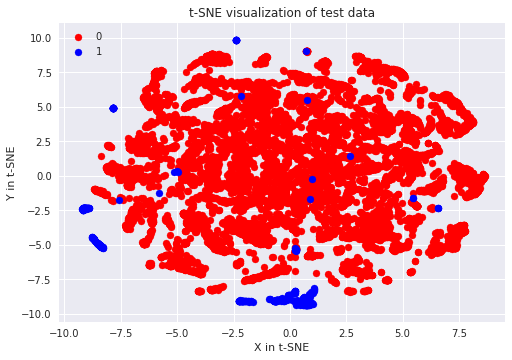

In [6]:

color_map = {0:'red', 1:'blue'}
plt.figure()
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x = x_test_2d[y==cl,0], 
                y = x_test_2d[y==cl,1], 
                c = color_map[idx], 
                label = cl)
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of test data')
plt.show()

In [ ]:

df_used = Fraud


df_used = pd.concat([df_used, Normal.sample(n = 10000)], axis = 0)

In [ ]:

df_used_std = standard_scaler.fit_transform(df_used)


y_used = df_used.ix[:,-1].values

In [ ]:
x_test_2d_used = tsne.fit_transform(df_used_std)

In [ ]:
color_map = {1:'red', 0:'blue'}
plt.figure()
for idx, cl in enumerate(np.unique(y_used)):
    plt.scatter(x=x_test_2d_used[y_used==cl,0], 
                y=x_test_2d_used[y_used==cl,1], 
                c=color_map[idx], 
                label=cl)
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of test data')
plt.show()